# 载入套件

In [1]:
from typing import Dict
from tqdm.auto import tqdm

import numpy as np
import random
import pandas as pd
import ydata_profiling

import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

import torch
import os

%matplotlib inline

pd.plotting.register_matplotlib_converters()
sns.set_style("whitegrid")
sns.set_palette("RdBu")
sns.set(
    rc={'text.usetex': True},
    font="serif",
    font_scale=1.2
)

days = {i: pd.read_pickle(f'../Datasets/day{str(i).zfill(2)}.pkl')
        for i in range(1, 22)}


# 监测表格

该数据来自某公司某年连续30天的4万多智能手机用户的监测数据，已经做了脱敏和数据变换处理。每天的数据为1个txt文件，共10列，记录了每个用户（以uid为唯一标识）每天使用各款APP（以appid为唯一标识）的起始时间，使用时长，上下流量等。

| 变量名        | 释义                          |
|------------|-----------------------------|
| uid        | 用户的id                       |
| appid      | APP的id（与app_class文件中的第一列对应） |
| app_type   | APP类型：系统自带、用户安装             |
| start_day  | 使用起始天，取值1-30                |
| start_time | 使用起始时间                      |
| end_day    | 使用结束天                       |
| end_time   | 使用结束时间                      |
| duration   | 使用时长（秒）                     |
| up_flow    | 上行流量                        |
| down_flow  | 下行流量                        |

# 单一变量

In [2]:
# 发现：数据集存在中文['用户', '预装']
temp = days[2].select_dtypes('category').describe()
temp


,uid,appid,app_type,app_class
count,5238514,5238514,5238514,5238514
unique,35257,10865,4,21
top,1FA08FD291312F1645BF1BB9371DDFB8,3309,usr,NaN
freq,3156,887965,2895265,2427834


In [3]:
app_type = set({})
for i in range(1, 22):
    app_type = app_type.union(days[i]['app_type'].unique())
app_type


{'sys', 'usr', '用户', '预装'}

In [4]:
for i in range(1, 22):
    days[i].replace({'用户': 'usr', '预装': 'sys'}, inplace=True)


# 天数变化

In [5]:
data = {'day': [], 'cat': [], 'val': []}
for i in range(1, 22):
    temp = days[i].select_dtypes('category').describe()
    # 日活跃用户
    data['day'].append(i)
    data['cat'].append('users')
    data['val'].append(temp.loc['unique', 'uid'])

    # 日志
    data['day'].append(i)
    data['cat'].append('logs')
    data['val'].append(temp.loc['count', 'uid'])

    # APP
    data['day'].append(i)
    data['cat'].append('apps')
    data['val'].append(temp.loc['unique', 'appid'])
temp = pd.DataFrame(data)


/Users/durui/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/durui/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/durui/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


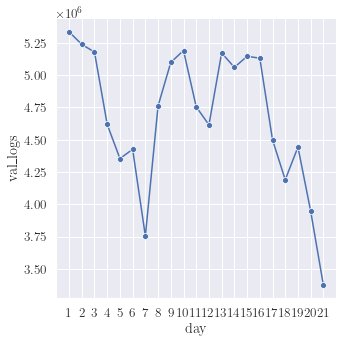

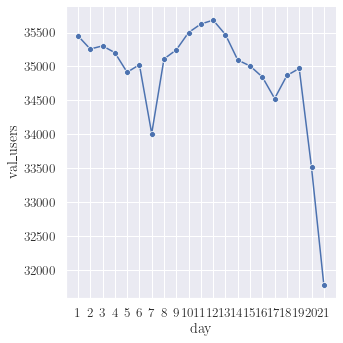

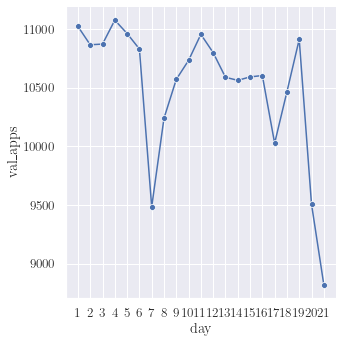

In [6]:
for cat in ['logs', 'users', 'apps']:
    g = sns.relplot(kind='line',
                    data=temp[temp['cat'] == cat],
                    x='day',
                    y='val',
                    marker='o')
    g.set(
        ylabel=f'val_{cat}',
        xticks=range(1, 22)
    )
    plt.savefig(f'../Thesis/figures/relplot_line_day_val_{cat}.pdf',
                dpi=400,
                bbox_inches='tight',
                pad_inches=0)


# 变量关联

In [7]:
# dfs = []
# for i in range(1, 22):
#     dfs.append(days[i][['appid', 'app_type', 'app_class']].drop_duplicates())
# ((pd.concat(dfs, ignore_index=True)).drop_duplicates()
#  ).to_pickle('../Datasets/app.pkl')


In [8]:
app = pd.read_pickle('../Datasets/app.pkl')
app['appid'] = app['appid'].astype('category')
app.select_dtypes('category').describe()


,appid,app_type,app_class
count,37276,37276,37276
unique,36437,2,21
top,19582,usr,NaN
freq,2,34153,32958


In [9]:
app.groupby('appid').count().query('app_class == 2')


,app_type,app_class
appid,,
4,2,2
50,2,2
61,2,2
62,2,2
70,2,2
...,...,...
49816,2,2
54481,2,2
57280,2,2


In [10]:
days[1][(days[1]['appid'] == 4) & (days[1]['app_type'] == 'usr')
        & (days[1]['uid'] == '91C16B1FE338DA085CB0B0840D8C6BA5')]


,uid,appid,app_type,app_class,start_day,start_time,end_day,end_time,duration,up_flow,down_flow
5321028,91C16B1FE338DA085CB0B0840D8C6BA5,4,usr,g,1,19:47:58,1,19:48:02,4,317,1160


/Users/durui/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


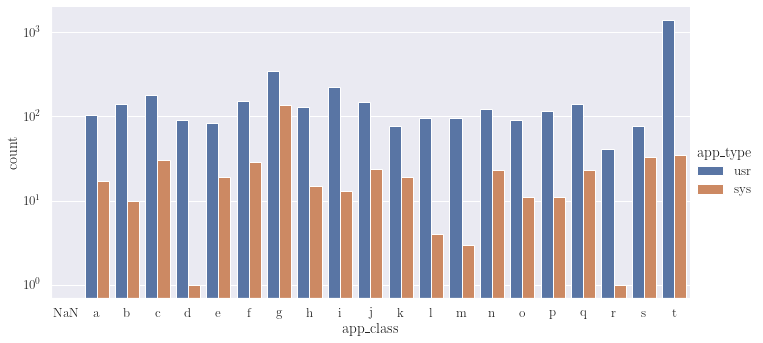

In [11]:
g = sns.catplot(kind='count', data=app.query("app_class != 'NaN'"), x='app_class',
                hue='app_type', hue_order=['usr', 'sys'],
                height=5, aspect=10/5)
plt.yscale('log')
plt.savefig("../Thesis/figures/catplot_count_app_class.pdf",
            dpi=400, bbox_inches='tight', pad_inches=0.005)
